In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from PIL import Image
import os
import pandas as pd
import numpy as np
import random
import cv2
import csv
import os, sys, time, datetime, random
import torch.utils.data
from tqdm import tqdm

sys.path.append('../../')
from image_size import get_image_size # source: https://github.com/scardine/image_size

In [2]:
DIR_PATH = '/Users/alexdrozdz/Desktop/Studia/00. Seminarium magisterskie/'

In [3]:
def from_tsv_to_list(path):
    tsv_file = open(path)
    read_tsv = csv.reader(tsv_file, delimiter=";")

    expected = list(read_tsv)[0]
    
    return expected

In [4]:
# train
expected_train = from_tsv_to_list(DIR_PATH + 'Master_gonito/train/expected.tsv')
in_train = from_tsv_to_list(DIR_PATH + 'Master_gonito/train/in.tsv')

# val
expected_val = from_tsv_to_list(DIR_PATH + 'Master_gonito/dev-0/expected.tsv')
in_val = from_tsv_to_list(DIR_PATH + 'Master_gonito/dev-0/in.tsv')

# test
expected_test = from_tsv_to_list(DIR_PATH + 'Master_gonito/test-A/expected.tsv')
in_test = from_tsv_to_list(DIR_PATH + 'Master_gonito/test-A/in.tsv')

In [5]:
def show_random_img_with_all_annotations(in_list, expected_list, path_to_photos, matplotlib_colours_list, pages=5):
    for page in range(pages):
        random_img = random.randint(0,len(in_list))
        file_name = in_list[random_img]
        print(file_name)

        with cbook.get_sample_data(path_to_photos + file_name) as image_file:
            image = plt.imread(image_file)

        fig, ax = plt.subplots(figsize=(15, 10))
        ax.imshow(image, cmap='gray')

        annotations = expected_list[random_img].split(' ')
        for i in range(len(annotations)):
            bbox = annotations[i].split('/')[1]
            x0 = int(bbox.split(',')[0])
            y0 = int(bbox.split(',')[1])
            width = int(bbox.split(',')[2])
            height = int(bbox.split(',')[3])
            cat_id = int(annotations[i].split('/')[0])
            rect = matplotlib.patches.Rectangle(
                (x0, y0), 
                width, 
                height, 
                linewidth=1, 
                edgecolor=matplotlib_colours_list[cat_id], 
                facecolor='none'
            )
                
            ax.add_patch(rect)           
            ax.text(
                x0, 
                y0, 
                cat_id, 
                fontsize=8,
                backgroundcolor='black',
                color=matplotlib_colours_list[cat_id]
            )

        plt.show()

1265.jpg


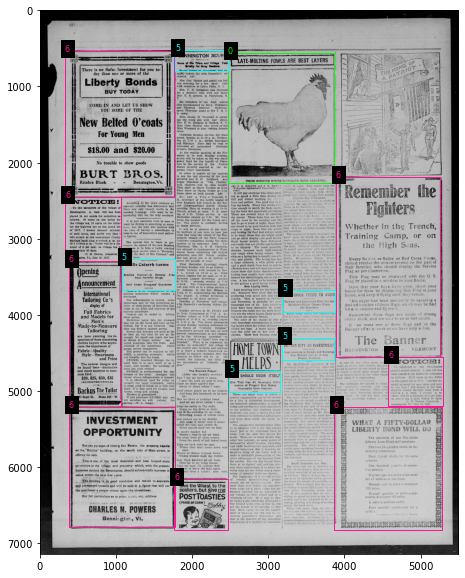

1737.jpg


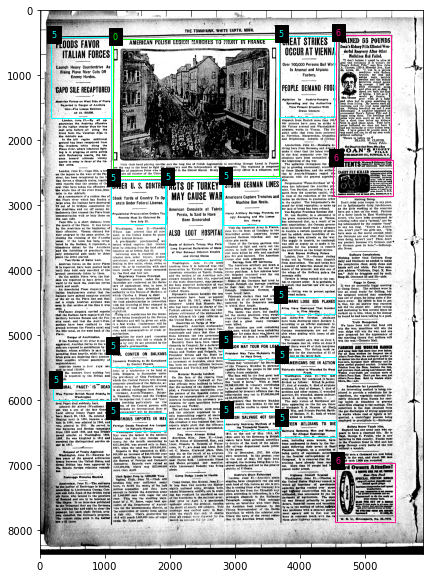

1007.jpg


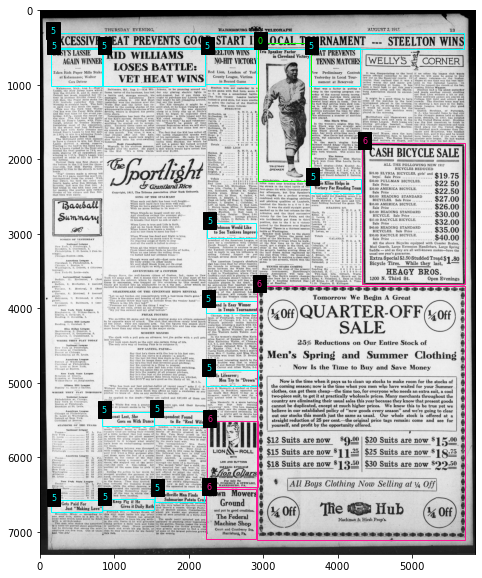

3080.jpg


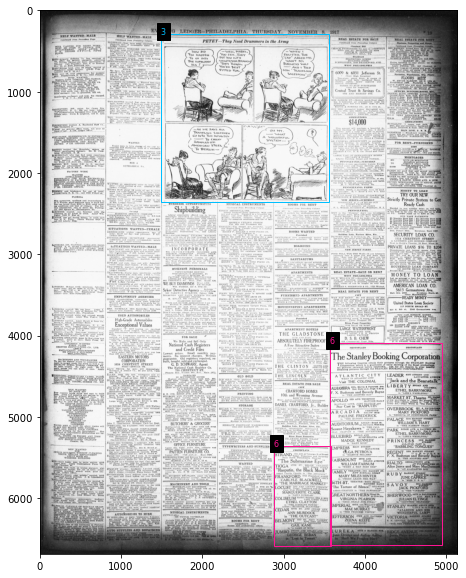

1697.jpg


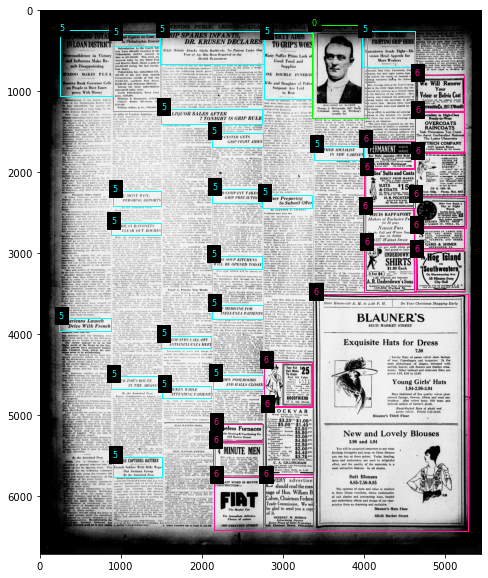

In [6]:
# some random images with annotations
show_random_img_with_all_annotations(
    in_train,
    expected_train,
    DIR_PATH+'scraped_photos_final/',
    ['lime','orangered','yellow','deepskyblue','violet','cyan','deeppink'],
    5
)

In [7]:
def create_df(in_list, expected_list):
    df = pd.DataFrame()
    for i in tqdm(range(len(in_list))):
        expected_list_split = expected_list[i].split(' ')
        for ii in range(len(expected_list_split)):
            expected_list_split_2 = expected_list_split[ii].split('/')
            bbox = expected_list_split_2[1].split(',')
            temp_dict = {
                'name': in_list[i],
                'class': expected_list_split_2[0],
                'x0': bbox[0],
                'y0': bbox[1],
                'width': bbox[2],
                'height': bbox[3],
            }
            df = df.append(temp_dict, ignore_index=True)
            
    return df

In [8]:
# train
train_df = create_df(in_train, expected_train)

# val
val_df = create_df(in_val, expected_val)

# test
test_df = create_df(in_test, expected_test)

100%|██████████| 712/712 [00:20<00:00, 34.29it/s]


In [9]:
train_df

,name,class,x0,y0,width,height
0,1.jpg,0,3672,552,1626,2029
1,1.jpg,6,456,606,2376,2347
2,1.jpg,6,3684,576,1572,2479
3,1.jpg,6,2070,3007,816,714
4,1.jpg,6,2076,3704,804,624
...,...,...,...,...,...,...
35594,3560.jpg,5,2700,3354,630,228
35595,3560.jpg,5,3954,3342,642,486
35596,3560.jpg,5,3312,4188,654,408
35597,3560.jpg,5,2046,5028,654,336


In [10]:
def get_target_ds(name, df):
    rows = df[df["name"] == name[:-4]]
    return rows["class"].values, rows[bboxes_cols].values

In [11]:
class Pytorch_dataset(torch.utils.data.Dataset):
    def __init__(self, images_path, df):
        super(ChessDataset, self).__init__()
        self.images_path = images_path
        self.df = df
  
    def __len__(self):
        return len(self.images_path)
   
    def __getitem__(self,idx):
        img_path = self.images_path[idx]
        img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
        target = {}
        labels, boxes = get_target_ds(img_path.name, self.df)
        areas = boxes[:,2] * boxes[:,3]
        iscrowd = torch.zeros((boxes.shape[0],))
        image_id = torch.tensor([idx])
        labels = torch.as_tensor(labels, dtype=torch.float32)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        target["boxes"] = boxes
        target["labels"] = labels
        target["areas"] = areas
        target["iscrowd"] = iscrowd
        target["image_id"] = image_id
        img = F.to_tensor(img)
        
        return img, target

In [14]:
from fastai import *
from fastai.vision.all import *
from fastai.imports import *

In [15]:
train_images = get_image_files(DIR_PATH + "scraped_photos_final")
dataset = Pytorch_dataset(train_images, train_df)
img , target = dataset.__getitem__(1)
size = img.shape
print(img.shape, target["boxes"], target["labels"])
plt.imshow(img.permute(1,2,0))

NameError: name 'df' is not defined